In [301]:
import pandas as pd
import quantstats as qs
import numpy as np
import talib
import ray

from functions.utils.system import *
from functions.utils.func import *
from prep_factor import PrepFactor
from fredapi import Fred
from pandas.tseries.offsets import BDay

import warnings

warnings.filterwarnings('ignore')

### Data

In [276]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

In [277]:
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')
window = 252
threshold = 2_000_000_000
hold_period = 21
stock = read_stock(get_large_dir(live) / 'permno_live.csv')

In [280]:
rf = pd.read_parquet(get_parquet_dir(live) / 'data_rf.parquet.brotli')
rf = rf.ffill()
rf = create_multi_index(rf, stock)
cap = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
price_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')

In [281]:
price_data = price_data.merge(rf, left_index=True, right_index=True, how='left')
price_data = price_data.merge(cap, left_index=True, right_index=True, how='left')
price_data['RF'] = price_data.groupby('permno')['RF'].ffill()

### Create Metrics

In [270]:
def compound_returns(x, window):
    return (1 + x).rolling(window).apply(lambda y: y.prod(), raw=True) - 1

In [282]:
price_data = create_return(price_data, [1])
price_data['com_ret'] =  price_data.groupby('permno')['RET_01'].transform(compound_returns, window)
price_data['com_ret_excess'] = price_data['com_ret'] - price_data['RF']

### Strategy

#### Create Signals

In [298]:
@ray.remote
def process_stock(data, permno, hold_period):
    positions = {}
    hold_counter = 0
    current_position = None
    stock_data = get_stock_data(data, permno).copy(deep=True)
    stock_data['position'] = None
    stock_data['start_position'] = False
    
    for index, row in stock_data.iterrows():
        if hold_counter > 0:
            hold_counter -= 1
            stock_data.at[index, 'position'] = current_position
            stock_data.at[index, 'start_position'] = False
        else:
            if row['com_ret_excess'] > 0:
                current_position = 'long'
                hold_counter = hold_period - 1
                stock_data.at[index, 'position'] = current_position
                stock_data.at[index, 'start_position'] = True
            elif row['com_ret_excess'] < 0:
                current_position = 'short'
                hold_counter = hold_period - 1
                stock_data.at[index, 'position'] = current_position
                stock_data.at[index, 'start_position'] = True
            else:
                current_position = None
                stock_data.at[index, 'position'] = current_position
                stock_data.at[index, 'start_position'] = False

    return stock_data[['position', 'start_position']]

def create_position(price, hold_period, batch_size):
    data = price.copy(deep=True)
    unique_permnos = data.index.get_level_values('permno').unique()
    batches = np.array_split(unique_permnos, np.ceil(len(unique_permnos) / batch_size))
    num_batches = len(batches)
    
    futures = []
    for i, batch in enumerate(batches):
        print(f"Processing batch: {i + 1}/{num_batches}")
        batch_futures = [process_stock.remote(data, permno, hold_period) for permno in batch]
        futures.extend(batch_futures)

    batch_results = ray.get(futures)
    print("Adding items to dataframe...")
    combine = pd.concat(batch_results, axis=0)
    combine = combine.sort_index(level=['permno', 'date'])
    data = data.merge(combine, left_index=True, right_index=True, how='left')
    return data

In [299]:
ray.init(num_cpus=16, ignore_reinit_error=True)
batch_size = 200
price = create_position(price_data, hold_period, batch_size)
ray.shutdown()

2023-12-17 21:09:57,200	INFO worker.py:1642 -- Started a local Ray instance.


Processing batch: 1/5
Processing batch: 2/5
Processing batch: 3/5
Processing batch: 4/5
Processing batch: 5/5
Adding items to dataframe...


#### Retrieve Stocks

In [333]:
@ray.remote
def select_long_short_stocks(day, data, hold_period):    
    # Select top and bottom stocks for dates with start_position
    group = data.loc[data.index.get_level_values('date') == day]
    start_positions = group[group['start_position']]
    top_stocks = start_positions.nlargest(25, 'inv_vol_com_ret_excess').index.get_level_values('permno').unique().tolist()
    bottom_stocks = start_positions.nsmallest(25, 'inv_vol_com_ret_excess').index.get_level_values('permno').unique().tolist()
    selected_permnos = top_stocks + bottom_stocks
    # Retrieve subsequent 20-day data for these stocks
    collect = []
    if selected_permnos == []:
        return
    
    start_date = day
    end_date = start_date + BDay(hold_period)
    stock_window = set_timeframe(data, start_date, end_date)  
    stock_window = get_stocks_data(stock_window, selected_permnos)
    top_mask = stock_window.index.get_level_values('permno').isin(top_stocks)
    bottom_mask = stock_window.index.get_level_values('permno').isin(bottom_stocks)
    stock_window['final_weight'] = 0 
    stock_window.loc[top_mask, 'final_weight'] = stock_window['inv_vol_com_ret_excess'].abs()
    stock_window.loc[bottom_mask, 'final_weight'] = -stock_window['inv_vol_com_ret_excess'].abs()
    return stock_window

def exec_select(data, hold_period, batch_size):
    unique_days = data.index.get_level_values('date').unique()
    batches = [unique_days[i:i + batch_size] for i in range(0, len(unique_days), batch_size)]
    num_batches = len(batches)
    
    futures = []
    for i, batch in enumerate(batches):
        print(f"Dispatching batch {i + 1}/{num_batches} for processing...")
        batch_futures = [select_long_short_stocks.remote(day, data, hold_period) for day in batch]
        futures.extend(batch_futures)

    results = ray.get(futures)
    combined_data = pd.concat(results, axis=0)
    return combined_data

In [334]:
price_copy = price.copy(deep=True)

In [335]:
price_copy['RET_01_shift'] = price_copy.groupby('permno')['RET_01'].shift(-1)
price_copy = price_copy.loc[price_copy.market_cap > threshold]

In [336]:
price_copy['vol'] = price_copy.groupby('permno')['RET_01'].transform(lambda x: x.rolling(21).std())
price_copy['inv_vol'] = 1 / price_copy['vol']
price_copy['inv_vol_com_ret_excess'] = price_copy['inv_vol'] * price_copy['com_ret_excess']

In [337]:
ray.init(num_cpus=16, ignore_reinit_error=True)
long_short = exec_select(data=price_copy, hold_period=hold_period, batch_size=200)
ray.shutdown()

2023-12-17 21:38:48,915	INFO worker.py:1476 -- Calling ray.init() again after it has already been called.


Dispatching batch 1/24 for processing...
Dispatching batch 2/24 for processing...
Dispatching batch 3/24 for processing...
Dispatching batch 4/24 for processing...
Dispatching batch 5/24 for processing...
Dispatching batch 6/24 for processing...
Dispatching batch 7/24 for processing...
Dispatching batch 8/24 for processing...
Dispatching batch 9/24 for processing...
Dispatching batch 10/24 for processing...
Dispatching batch 11/24 for processing...
Dispatching batch 12/24 for processing...
Dispatching batch 13/24 for processing...
Dispatching batch 14/24 for processing...
Dispatching batch 15/24 for processing...
Dispatching batch 16/24 for processing...
Dispatching batch 17/24 for processing...
Dispatching batch 18/24 for processing...
Dispatching batch 19/24 for processing...
Dispatching batch 20/24 for processing...
Dispatching batch 21/24 for processing...
Dispatching batch 22/24 for processing...
Dispatching batch 23/24 for processing...
Dispatching batch 24/24 for processing...


#### Calculate Total Returns

In [339]:
keep = long_short.copy(deep=True)

In [340]:
long_short = long_short.sort_index(level=['permno', 'date'])

In [343]:
long_short['final_weight'] /= long_short.groupby('date')['final_weight'].transform(lambda x: x.abs().sum())
long_short['weighted_RET_01'] = long_short['RET_01_shift'] * long_short['final_weight']

In [344]:
total_ret = long_short.groupby('date')['weighted_RET_01'].sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2006-01-04   2006-01-04
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          247.76%      -64.27%
CAGR﹪                     4.94%        -3.9%

Sharpe                     0.45         -0.31
Prob. Sharpe Ratio         97.16%       9.77%
Smart Sharpe               0.44         -0.3
Sortino                    0.63         -0.43
Smart Sortino              0.61         -0.42
Sortino/√2                 0.45         -0.31
Smart Sortino/√2           0.43         -0.29
Omega                      0.94         0.94

Max Drawdown               -56.47%      -76.93%
Longest DD Days            1982         5469
Volatility (ann.)          19.79%       15.08%
R^2                        0.0          0.0
Information Ratio          -0.03        -0.03
Calmar        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-11-20,2023-02-01,2023-11-10,5469,-76.932129,-76.066797
2,2008-10-10,2008-11-03,2008-11-13,35,-14.357219,-13.357040
3,2006-04-20,2007-06-25,2008-01-02,623,-13.968818,-13.746651
4,2008-07-15,2008-08-29,2008-10-02,80,-10.297037,-10.145275
5,2008-01-14,2008-03-20,2008-06-18,157,-9.077321,-8.664565


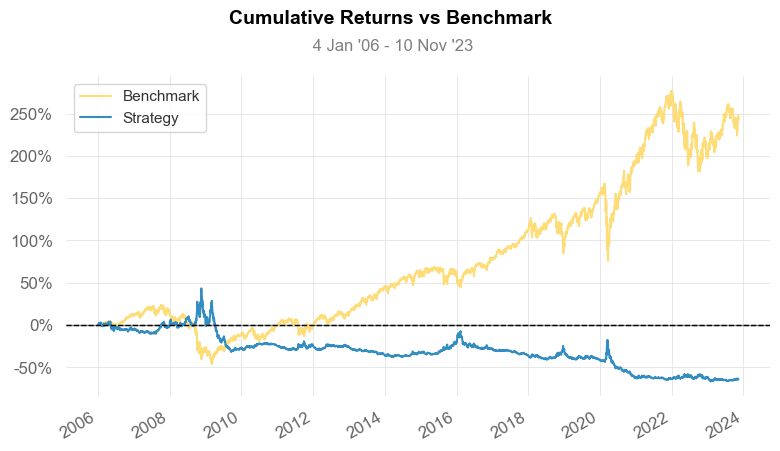

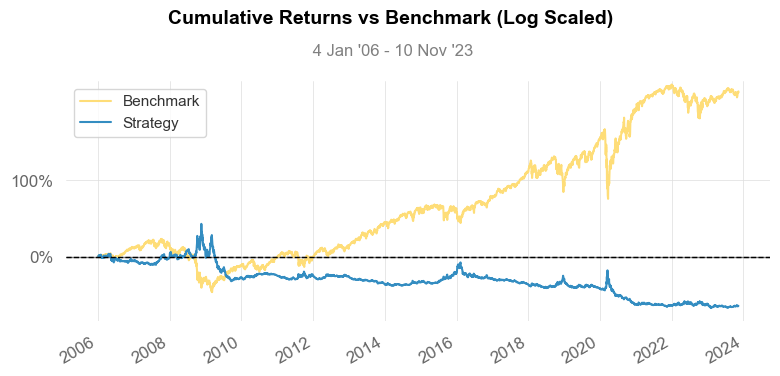

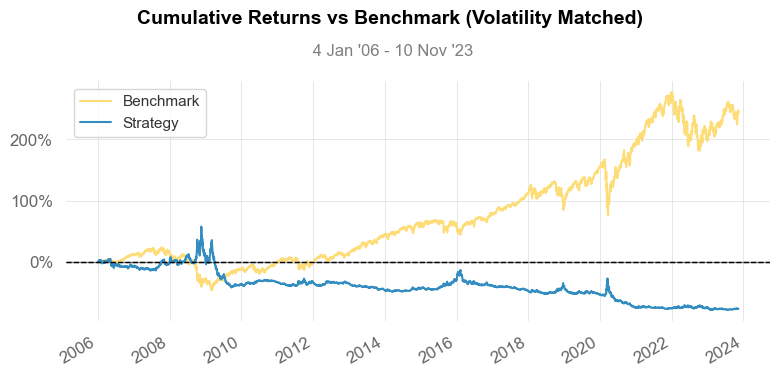

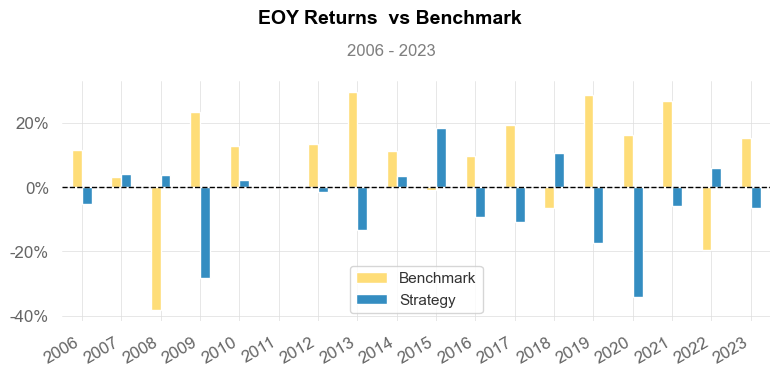

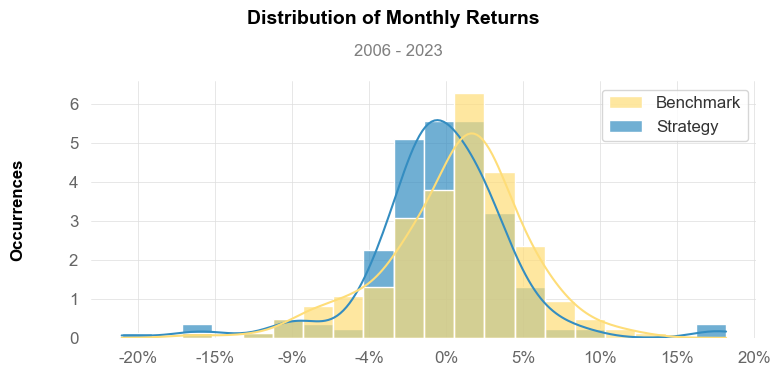

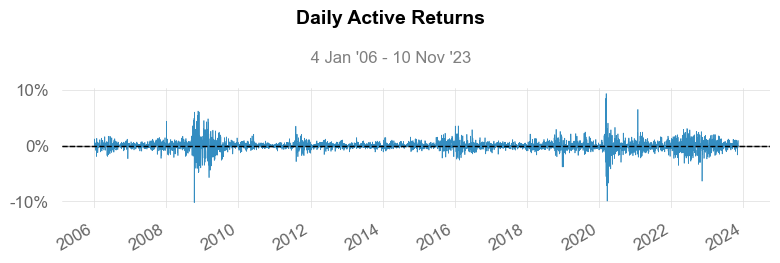

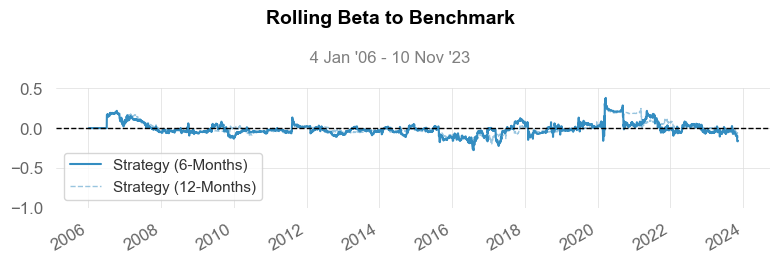

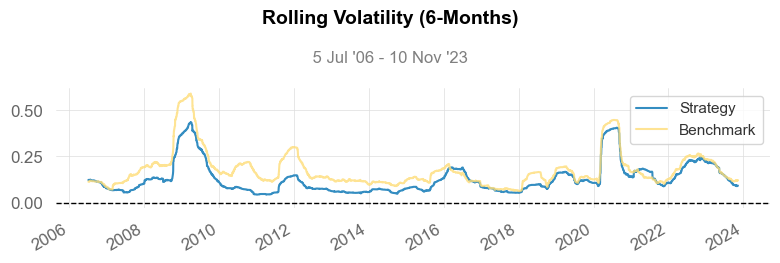

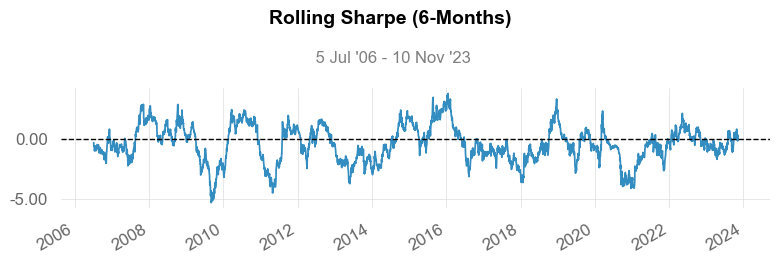

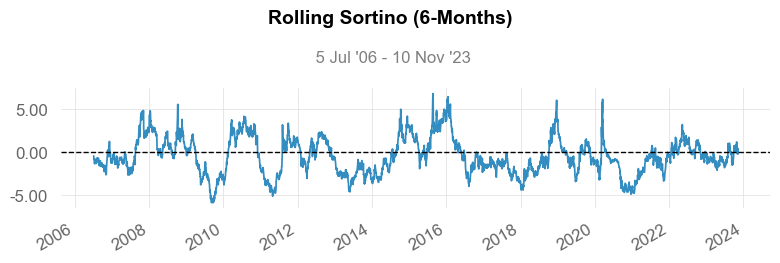

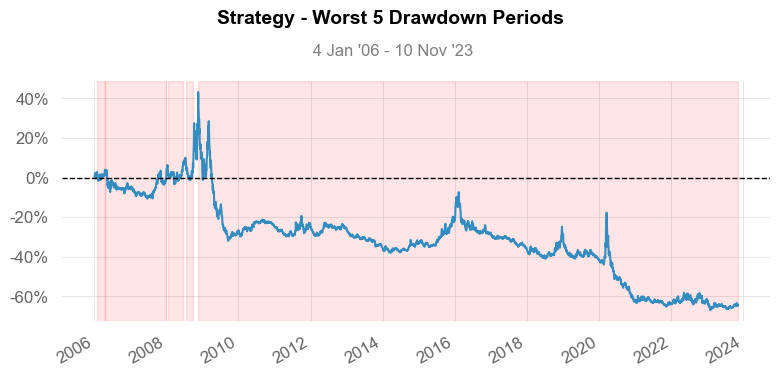

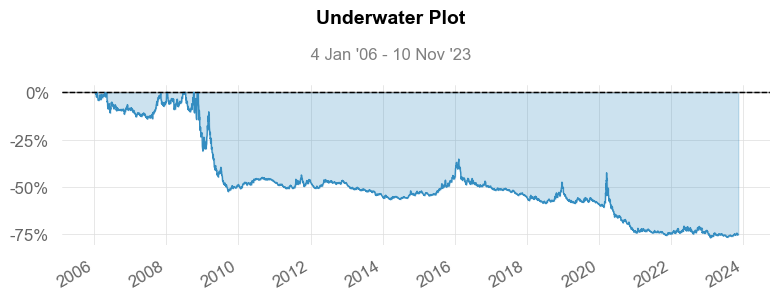

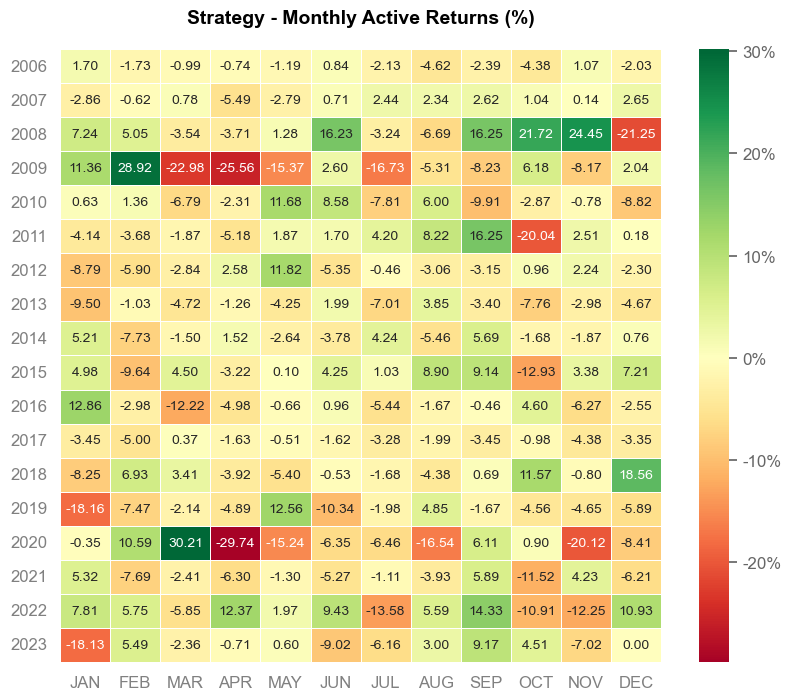

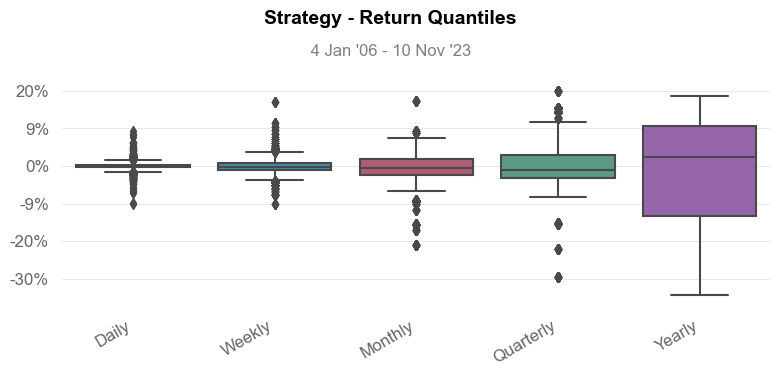

In [345]:
qs.reports.full(total_ret, 'SPY')